In [2]:
import pandas as pd
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

import numpy as np

import sklearn
import scikit_posthocs as sp
import statsmodels.formula.api as sfa
import statsmodels.api as sa
import os
from pathlib import Path

import scipy
import neurokit2 as nk

import tqdm 


from collections import Counter
import matplotlib.pyplot as plt


In [3]:
lstPIds = []
path = "./final test data/"
for filename in os.listdir(path):
    if filename.endswith(".csv"): 
        lstPIds.append(int(filename.split("-")[0].replace("ID", "")))
    else:
        continue
lstPIds = list(set(lstPIds))
print(lstPIds)

[201, 202, 203, 204]


In [10]:
lstAll = []
for pid in tqdm.tqdm(lstPIds):
    
    dfState = pd.read_csv(f"{path}ID{pid}-state.csv")

    dfStart = dfState[dfState.State == "start"].copy()
    dfEnd = dfState[dfState.State == "end"][["Time"]].iloc[:len(dfStart)]
    dfStart = dfStart.rename(columns={"Time":"TimeStart"})
    dfStart.TimeStart = dfStart.TimeStart #+ 60
    dfStart["TimeEnd"] = dfEnd.Time.values
    del dfStart["State"]
    dfStart["Duration"] = dfStart.TimeEnd - dfStart.TimeStart
    df = dfStart[dfStart.BlockNumber != -2].copy()

    dfNBack = pd.read_csv(f"{path}ID{pid}-feedback.csv")
    dfNBack = dfNBack[dfNBack.Time != "Time"]
    correct= (dfNBack["IsCorrect"]==True).count()

    lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time < e.TimeEnd )]
        if (len(dfX) == 0):
            print("No Data!")
        lstNBack.append(dfX.IsCorrect.mean())
    df["IsCorrect"] = lstNBack

    lstCorrectCount = []
    lstTotalTouchCount = []
    #lstNBack = []
    for i, e in df.iterrows():
        dfX = dfNBack[(dfNBack.Time > e.TimeStart) & (dfNBack.Time <= e.TimeEnd )]
        lstCorrectCount.append(len(dfX[dfX.IsCorrect == True]))
        lstTotalTouchCount.append(len(dfX))
    
    dfSphere = pd.read_csv(f"{path}ID{pid}-sphere.csv")
    del dfSphere["Feedback"]
    
    lstMissedCount = []
    for i, e in df.iterrows():
        dfX = dfSphere[(dfSphere.Time > e.TimeStart) & (dfSphere.Time <= e.TimeEnd )].reset_index(drop=True)
        missed = 0
        for i in range(0, len(dfX)-1):
            if ((dfX.iloc[i].Type == "up") & (dfX.iloc[i+1].Type == "down")):
                if(dfX.iloc[i+1].Time-dfX.iloc[i].Time > 4):
                    missed += 1
        lstMissedCount.append(missed)
    
    df["NBackCorrect"] = lstCorrectCount
    df["NBackMissed"] = lstMissedCount
    df["NBackTotal"] = np.array(lstTotalTouchCount) + np.array(lstMissedCount)
    df["NBackAccuracy"] = df["NBackCorrect"]/df["NBackTotal"] * 100
    
    df["NBackTimePerBall"] = df["Duration"] / np.array(lstTotalTouchCount)
    
    
    # Read Flow File
    dfFlow = pd.read_csv(f"{path}ID{pid}-flow.csv")
    dfFlow["TimeNorm"] = dfFlow.Time-dfState.Time.iloc[0]

    # Read Visitor File
    #dfLiams = pd.read_csv(f"{path}ID{pid}-visitor.csv")
    #dfLiams = dfLiams.drop_duplicates(subset=['Name'])
    #dfLiams["TimeNorm"] = dfLiams.Time-dfState.Time.iloc[0]

   ## Calculate Accuracy
    lstLiamData = []
    for i, e in df.iterrows():
        dfX = dfFlow[(dfFlow.Time > e.TimeStart) & (dfFlow.Time < e.TimeEnd )]
       
        if ((len(dfX) == 0)):
            print("No Data! Liams" + str(i))
           
        lstLiamData.append(len(dfX))
        
    #lstLiamClickData.append([total, truePositive, falsePositive, trueNegatives, falseNegatives])
    #lstLiamClickData = np.array(lstLiamClickData)
    df["LiamsCountTotal"] = lstLiamData
    #df["LiamsCounTruePositive"] = lstLiamClickData[:,1]
    #df["LiamsCountFalsePositive"] = lstLiamClickData[:,2]
    #df["LiamsCountTrueNegatives"] = lstLiamClickData[:,3]
    #df["LiamsCountFalseNegatives"] = lstLiamClickData[:,4]

   # df["Accuracy"] = (df.LiamsCounTruePositive +  df.LiamsCountTrueNegatives) / df.LiamsCountTotal
    df["Flow"] = df["LiamsCountTotal"] / df.Duration * 60
    # Read EDA
    dfEEG = pd.read_csv(f"{path}ID{pid}-EEG.csv")
    dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P4", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
    dfEEG["TimeNorm"] = dfEEG.Time-dfState.Time.iloc[0]
    sampling_freq = 300
    ch_names = ['F3','C3','P3','P4','C4','F4','Pz']
    ch_types = ['eeg'] * 7
    lstF3 = []
    lstC3 = []
    lstP3 = []
    lstP4 = []
    lstC4 = []
    lstF4 = []
    lstPz = []
    
    for i, e in df.iterrows():
        dfX = dfEEG[(dfEEG.Time > e.TimeStart) & (dfEEG.Time < e.TimeEnd )]
        lstF3.append(dfX["F3"])
        lstC3.append(dfX["C3"])
        lstP3.append(dfX["P3"])
        lstP4.append(dfX["P4"])
        lstC4.append(dfX["C4"])
        lstF4.append(dfX["F4"])
        lstPz.append(dfX["Pz"])
        
        dfX["F3"] = lstF3
        dfX["C3"] = lstC3
        dfX["P3"] = lstP3 
        dfX["P4"] = lstP4
        dfX["C4"] = lstC4
        dfX["F4"] = lstF4
        dfX["Pz"] = lstPz
        dfX["PId"] = pid
        lstAll.append(df)
    
dfAll = pd.concat(lstAll)
    

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipykernel_37502/2757857526.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfX["F3"] = np.asarray(lstF3).T
/tmp/ipykernel_37502/2757857526.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfX["C3"] = np.asarray(lstC3).T
/tmp/ipykernel_37502/2757857526.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

ValueError: Length of values (4) does not match length of index (107992)

In [81]:
dfEEG = dfEEG.drop(['Value7'], axis=1)
dfEEG

,Time,TimeLsl,F3,C3,P3,P4,C4,F4,Pz,TimeNorm
0,1.660734e+09,52078.779441,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
1,1.660734e+09,52078.779443,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
2,1.660734e+09,52078.779444,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
3,1.660734e+09,52078.779445,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
4,1.660734e+09,52078.779471,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
...,...,...,...,...,...,...,...,...,...,...
1247995,1.660738e+09,56238.959735,22.274,-12.702740,18.354190,32.524860,8.697998,31.849860,11.141760,4128.04982
1247996,1.660738e+09,56238.959736,0.000,-13.267040,-21.408170,-55.173770,-7.240534,-51.170980,-18.353160,4128.04982
1247997,1.660738e+09,56238.959737,41.839,-6.103251,15.907970,14.101370,24.642730,27.774460,17.167550,4128.04982
1247998,1.660738e+09,56238.959738,19.866,-4.557411,18.358380,43.081200,16.547420,33.032800,12.645090,4128.04982


In [57]:
dfEEG = dfEEG.rename(columns={"Value0": "F3", "Value1": "C3", "Value2": "P3", "Value3": "P3", "Value4": "C4", "Value5": "F4", "Value6": "Pz"})
dfEEG["TimeNorm"] = dfEEG.Time-dfState.Time.iloc[0]
sampling_freq = 300
ch_names = ['F3','C3','P3','P4','C4','F4','Pz']
ch_types = ['eeg'] * 7
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')




<Info | 8 non-empty values
 bads: []
 ch_names: F3, C3, P3, P4, C4, F4, Pz
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 150.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 300.0 Hz
>

In [82]:
dfEEG


,Time,TimeLsl,F3,C3,P3,P4,C4,F4,Pz,TimeNorm
0,1.660734e+09,52078.779441,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
1,1.660734e+09,52078.779443,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
2,1.660734e+09,52078.779444,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
3,1.660734e+09,52078.779445,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
4,1.660734e+09,52078.779471,9863.168,-17.157000,-17.157000,-16.254000,-22.575000,57.491000,4.214000,-32.13759
...,...,...,...,...,...,...,...,...,...,...
1247995,1.660738e+09,56238.959735,22.274,-12.702740,18.354190,32.524860,8.697998,31.849860,11.141760,4128.04982
1247996,1.660738e+09,56238.959736,0.000,-13.267040,-21.408170,-55.173770,-7.240534,-51.170980,-18.353160,4128.04982
1247997,1.660738e+09,56238.959737,41.839,-6.103251,15.907970,14.101370,24.642730,27.774460,17.167550,4128.04982
1247998,1.660738e+09,56238.959738,19.866,-4.557411,18.358380,43.081200,16.547420,33.032800,12.645090,4128.04982


<AxesSubplot:xlabel='TimeNorm'>

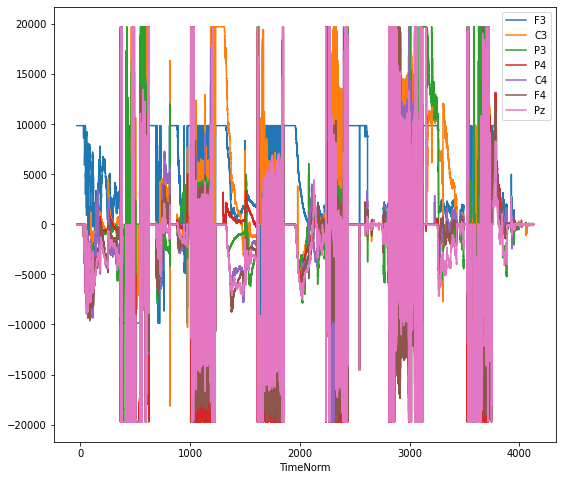

In [84]:
dfEEG.plot(x="TimeNorm", y=["F3", "C3","P3","P4","C4","F4","Pz"], figsize=(9, 8))
